In [2]:
pip install torch torchvision efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0fb8c53b07ce2f31a51c99499ad69b96dac1721bbe3535159b747ddf379f8328
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import os
from efficientnet_pytorch import EfficientNet

# 🚀 Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 📂 Dataset path
data_dir = "/kaggle/input/lung-cancer-dataset1"

# ✅ Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 📂 Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# 🚀 Load EfficientNet-B3 (Pretrained)
model = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model._fc.in_features
model._fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)
model = model.to(device)

# 🔥 Weighted Loss (Class Imbalance)
class_counts = np.bincount([label for _, label in train_dataset.samples])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# 🏋️ Training
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🚀 Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc:.4f}")

    scheduler.step(val_loss)

print("✅ Training complete.")

# 📊 Validation Metrics
precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')

print("\n🔍 **Validation Performance Metrics**")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")
print(f"✅ ROC AUC Score: {auc:.4f}")

# 📌 Validation Class-wise Accuracy
class_correct = {class_name: 0 for class_name in train_dataset.classes}
class_total = {class_name: 0 for class_name in train_dataset.classes}

for label, pred in zip(val_labels, val_preds):
    class_total[train_dataset.classes[label]] += 1
    if label == pred:
        class_correct[train_dataset.classes[label]] += 1

print("\n📌 **Class-wise Accuracy (Validation)**")
for class_name in train_dataset.classes:
    accuracy = class_correct[class_name] / class_total[class_name] * 100
    print(f"✅ {class_name}: {accuracy:.2f}%")

# 🚀 Test Set Evaluation
model.eval()
test_preds, test_labels = [], []
test_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        test_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 📊 Test Metrics
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')

print("\n📊 **Test Set Performance**")
print(f"✅ Accuracy: {test_acc:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1 Score: {test_f1:.4f}")
print(f"✅ ROC AUC Score: {test_auc:.4f}")

# 📌 Test Class-wise Accuracy
test_class_correct = {class_name: 0 for class_name in test_dataset.classes}
test_class_total = {class_name: 0 for class_name in test_dataset.classes}

for label, pred in zip(test_labels, test_preds):
    test_class_total[test_dataset.classes[label]] += 1
    if label == pred:
        test_class_correct[test_dataset.classes[label]] += 1

print("\n📌 **Class-wise Accuracy (Test)**")
for class_name in test_dataset.classes:
    accuracy = test_class_correct[class_name] / test_class_total[class_name] * 100
    print(f"✅ {class_name}: {accuracy:.2f}%")


Using device: cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 196MB/s]


Loaded pretrained weights for efficientnet-b3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10:
Train Loss: 0.6855, Train Accuracy: 0.6931
Val Loss: 0.4465, Val Accuracy: 0.8125
Epoch 2/10:
Train Loss: 0.3388, Train Accuracy: 0.8611
Val Loss: 0.3295, Val Accuracy: 0.8681
Epoch 3/10:
Train Loss: 0.2246, Train Accuracy: 0.9180
Val Loss: 0.2194, Val Accuracy: 0.8993
Epoch 4/10:
Train Loss: 0.2019, Train Accuracy: 0.9249
Val Loss: 0.0677, Val Accuracy: 0.9688
Epoch 5/10:
Train Loss: 0.1323, Train Accuracy: 0.9575
Val Loss: 0.0658, Val Accuracy: 0.9757
Epoch 6/10:
Train Loss: 0.0893, Train Accuracy: 0.9718
Val Loss: 0.0262, Val Accuracy: 0.9931
Epoch 7/10:
Train Loss: 0.0855, Train Accuracy: 0.9705
Val Loss: 0.0520, Val Accuracy: 0.9792
Epoch 8/10:
Train Loss: 0.0740, Train Accuracy: 0.9748
Val Loss: 0.0316, Val Accuracy: 0.9896
Epoch 9/10:
Train Loss: 0.0596, Train Accuracy: 0.9796
Val Loss: 0.0360, Val Accuracy: 0.9826
Epoch 10/10:
Train Loss: 0.0490, Train Accuracy: 0.9844
Val Loss: 0.0173, Val Accuracy: 0.9965
✅ Training complete.

🔍 **Validation Performance Metrics**


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


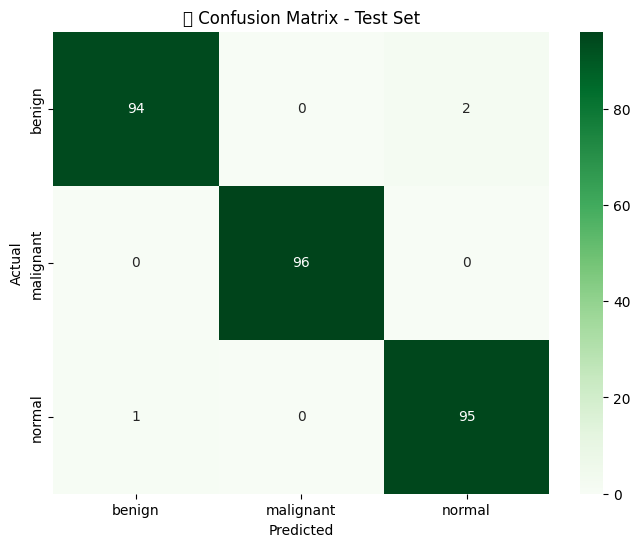

In [5]:
# 📌 Confusion Matrix (Test Set)
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("📊 Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


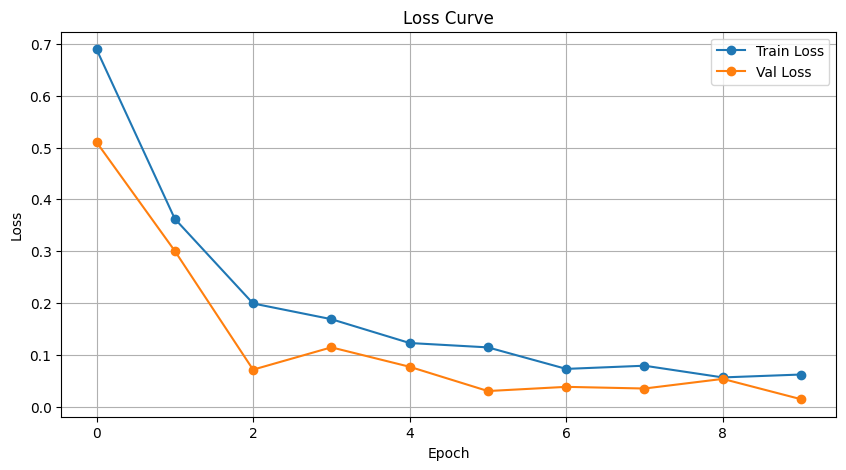

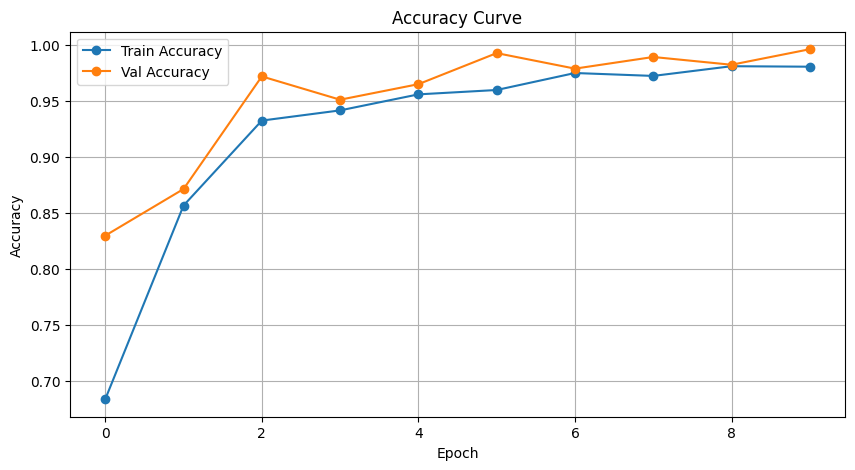

In [4]:
# 📈 Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📈 Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


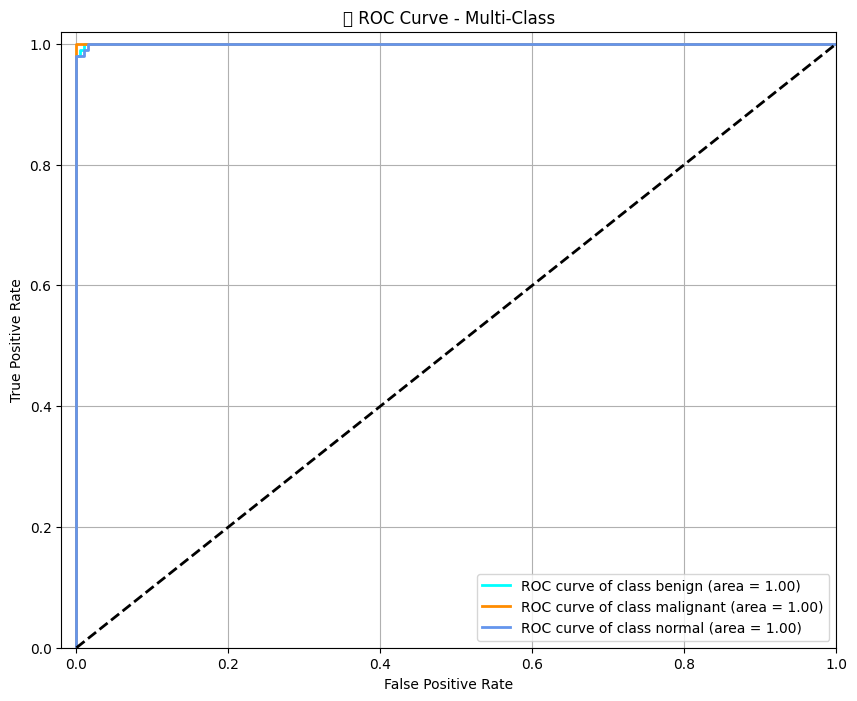

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the test labels
n_classes = len(test_dataset.classes)
y_test_bin = label_binarize(test_labels, classes=list(range(n_classes)))
y_score = np.array(test_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {test_dataset.classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve - Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
